In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import skimage as sk
import os
import cv2
import skimage.io
import sklearn

In [254]:
TEST = "Data/TEST/"
TRAIN = "Data/TRAIN/"

CSVs = []
IMGs = []
for i in os.listdir(TEST):
    if "csv" in i:
        CSVs.append(TEST + i)
    if "jpg" in i or "png" in i:
        IMGs.append(TEST + i)

CSVs = sorted(CSVs)
IMGs = sorted(IMGs)

print(CSVs, IMGs)

tables = [pd.read_csv(c, header=None) for c in CSVs]
images = [plt.imread(i) for i in IMGs]

['Data/TEST/ex01.csv', 'Data/TEST/ex02.csv', 'Data/TEST/ex03.csv', 'Data/TEST/ex04.csv', 'Data/TEST/ex05.csv'] ['Data/TEST/ex01.jpg', 'Data/TEST/ex02.jpg', 'Data/TEST/ex03.jpg', 'Data/TEST/ex04.jpg', 'Data/TEST/ex05.jpg']


Original Dimensions :  (1536, 2039, 3)
Resized Dimensions :  (230, 305, 3)


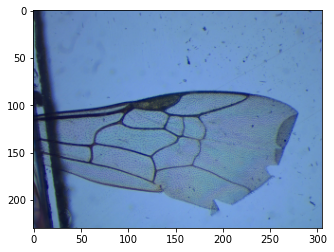

In [321]:
import cv2
 
input_image = images[4]
img = input_image.copy()
 
print('Original Dimensions : ', img.shape)
 
scale_percent = 15 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)

# resize image
reduced = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
 
print('Resized Dimensions : ',reduced.shape)
 
plt.imshow(reduced)

Original Dimensions :  (230, 305, 3)
Resized Dimensions :  (1536, 2039, 3)


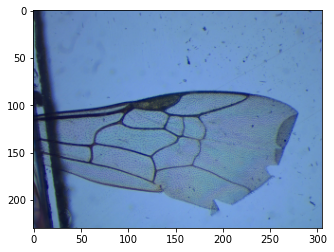

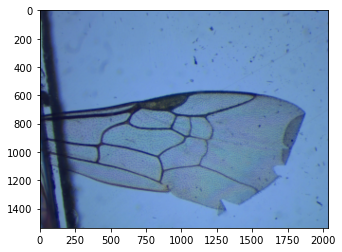

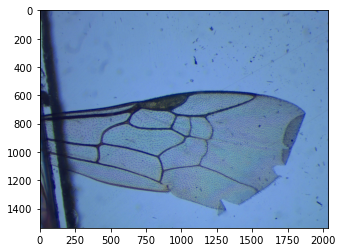

In [322]:
imz = reduced.copy()
img = reduced.copy()
 
print('Original Dimensions : ', img.shape)
 
scale_percent = 15 # percent of original size
width = int(input_image.shape[1])
height = int(input_image.shape[0])
dim = (width, height)

# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
 
print('Resized Dimensions : ', resized.shape)

plt.imshow(imz)
plt.show() 
plt.imshow(resized)
plt.show()
plt.imshow(input_image)
plt.show()

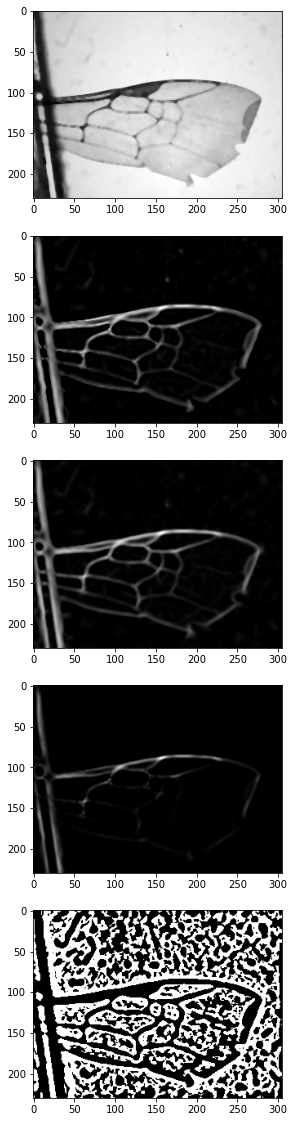

In [323]:
from skimage.filters import meijering, sato, frangi, hessian, gaussian, median
from skimage.color import rgb2gray
kwargs = {'sigmas': range(1, 5, 2), 'mode': 'reflect'}
img = rgb2gray(imz)
img_blurred = gaussian(img, sigma=4)
img_denoised = median(img, selem=np.ones((5,5)))
res = img_denoised
image = res
meij = meijering(image, **kwargs)
saato = sato(image, **kwargs)
frang = frangi(image, **kwargs)
hess = hessian(image, **kwargs)
f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5, 1, figsize=(15,20))
ax0.imshow(image, cmap='gray')
ax1.imshow(meij, cmap='gray')
ax2.imshow(saato, cmap='gray')
ax3.imshow(frang, cmap='gray')
ax4.imshow(hess, cmap='gray')

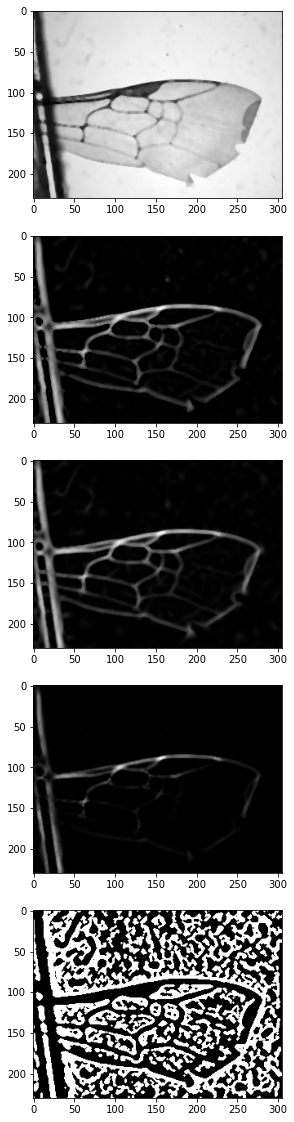

In [324]:
tmeij = meij.copy()
tsaato = saato.copy()
tfrang = frang.copy()
thess = hess.copy()

def remove_small(img):
    footprint = sk.morphology.disk(1)
    res = sk.morphology.white_tophat(img, footprint)
    arr = res > 0
    cleaned = sk.morphology.remove_small_objects(arr, min_size=2)
    return img - res
tmeij = remove_small(meij)
tsaato = remove_small(saato)
tfrang = remove_small(frang)
thess = remove_small(hess)
f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5, 1, figsize=(15,20))
ax0.imshow(image, cmap='gray')
ax1.imshow(tmeij, cmap='gray')
ax2.imshow(tsaato, cmap='gray')
ax3.imshow(tfrang, cmap='gray')
ax4.imshow(thess, cmap='gray')

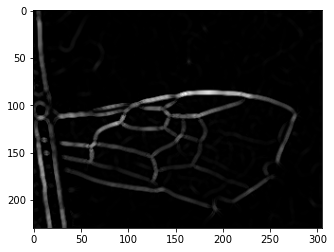

In [325]:
from skimage.morphology import disk, white_tophat, area_closing, skeletonize

image = tsaato.copy()

footprint = disk(3)
res = white_tophat(image, footprint)
res = area_closing(res, area_threshold=64, connectivity=10)
plt.imshow(res, cmap="gray")

In [326]:
thres = np.mean(res) / 2
res[res > thres] = 1
res[res <= thres] = 0

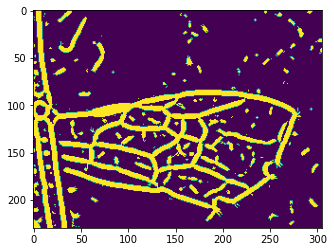

In [327]:
plt.imshow(res)

[None, None]

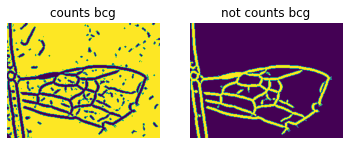

In [328]:
img_res = res.copy()
img_bw = img_res > 0
labels = skimage.measure.label(img_bw, return_num=False)

maxCC_withbcg = labels == np.argmax(np.bincount(labels.flat))
maxCC_nobcg = labels == np.argmax(np.bincount(labels.flat, weights=img_bw.flat))

fig, ax = plt.subplots(1, 2)
ax[0].imshow(maxCC_withbcg), ax[0].set_title('counts bcg')
ax[1].imshow(maxCC_nobcg), ax[1].set_title('not counts bcg')
[axi.set_axis_off() for axi in ax.ravel()]

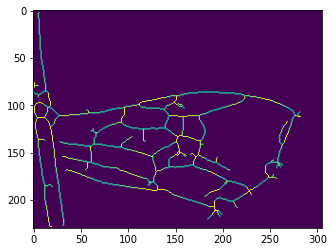

In [329]:
skel = skeletonize(maxCC_nobcg)
plt.imshow(skel)

Original Dimensions :  (230, 305)
Resized Dimensions :  (1536, 2039)


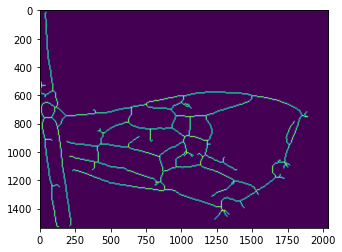

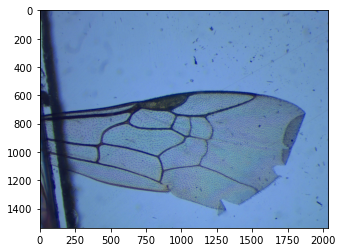

In [330]:
img = skel.copy()

img = np.float32(img)
 
print('Original Dimensions : ', img.shape)
 
width = int(input_image.shape[1])
height = int(input_image.shape[0])
dim = (width, height)

# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
 
print('Resized Dimensions : ', resized.shape)

plt.imshow(resized)
plt.show()
plt.imshow(input_image)
plt.show()

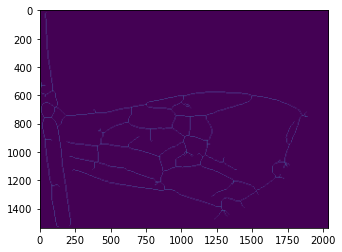

In [331]:
rescaled = skeletonize(resized)
plt.imshow(rescaled)

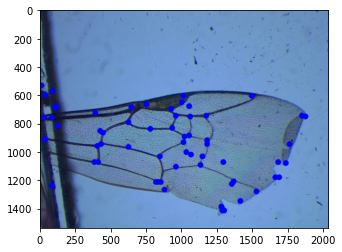

In [332]:
cpy_img = input_image.copy()
img = rescaled.copy()
gray = img
gray = np.float32(gray)

dst = cv2.cornerHarris(gray, 9, 3, 0.04)

# result is dilated for marking the corners
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img_thresh = cv2.threshold(dst, 0.5*dst.max(), 255, 0)[1]
img_thresh = np.uint8(img_thresh)

# get the matrix with the x and y locations of each centroid
centroids = cv2.connectedComponentsWithStats(img_thresh)[3]


stop_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 255, 0.001)
# refine corner coordinates to subpixel accuracy
corners = cv2.cornerSubPix(gray, np.float32(centroids), (5,5), (-1,-1), stop_criteria)
corners = np.round(corners)

for i in range(1, len(corners)):
    #print(corners[i])
    cv2.circle(cpy_img, (int(corners[i,0]), int(corners[i,1])), 10, (0,0,255), 20)
plt.imshow(cpy_img)
#plt.scatter([i[0] for i in corners], [i[1] for i in corners], color='b', marker="o")
plt.show()

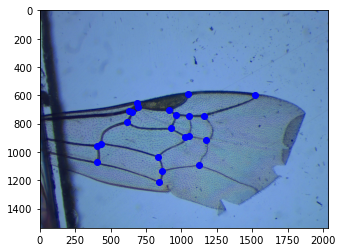

In [333]:
plt.imshow(input_image, cmap='gray')
plt.scatter(tables[4][1], tables[4][0], color='b', marker="o")
plt.show()

In [334]:
gt_corners = tables[0].to_numpy()

In [335]:
def similarity(a, b, threshold):
    #print(a, b)
    if abs(a[0] - b[1]) <= threshold and abs(a[1] - b[0]) <= threshold:
        return True
    return False
    
good_findings = 0
for i in gt_corners:
    for j in corners:
        if similarity(i, j, 70):
            good_findings += 1
good_findings

12

In [336]:
gt_corners, len(gt_corners)

(array([[ 485.,  870.],
        [ 495., 1109.],
        [ 546.,  677.],
        [ 548.,  857.],
        [ 570., 1015.],
        [ 578.,  710.],
        [ 690., 1173.],
        [ 692.,  526.],
        [ 736., 1433.],
        [ 808., 1038.],
        [ 834.,  216.],
        [ 846.,  184.],
        [ 911., 1166.],
        [ 978.,   85.],
        [ 977.,  749.],
        [1010., 1556.],
        [1020., 1474.],
        [1214.,  781.],
        [1233., 1305.]]),
 19)